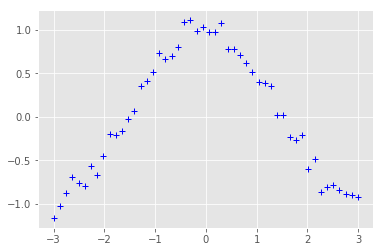

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from edward.models import Normal, Beta, Bernoulli, Uniform, Empirical

import edward as ed

x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))
plt.show()
plt.style.use('ggplot')
plt.plot(x_train,y_train,'b+')
plt.show()

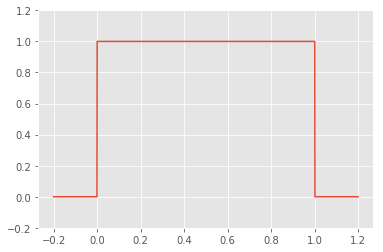

In [2]:
sess = ed.get_session()
x = tf.range(-0.2, 1.2, 0.001)
plt.plot(*sess.run([x, Uniform(low=0.0, high=1.0).prob(x)]));
#plt.plot(*sess.run([x, Beta(concentration1=1.0, concentration0=1.0).prob(x)]));
plt.ylim((-0.2, 1.2));

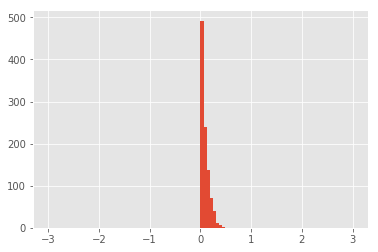

In [3]:
from edward.models import Beta,Bernoulli,Normal,Uniform, Empirical
import edward as ed
x_data = np.array([0,1,0,0,0,0,0,0,1,1])
p = Beta(1.0,10.0)
samples = sess.run(p.sample(1000))
plt.hist(samples, bins=100, range=(-3.0, 3.0))
plt.show()
#x = Bernoulli(probs=p, sample_shape=10)
#qp=Empirical(tf.Variable(tf.ones(10000)/2))
#inference = ed.Gibbs({p:qp}, data={x:x_data})
#inference.run()
#print(qp.params.eval())

In [5]:
theta = tf.Variable(0.0) 
x = Bernoulli(tf.ones(50) * tf.sigmoid(theta)) # likelihood
tf.global_variables_initializer().run()
x.eval() # get 50 samples of x 

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0], dtype=int32)

In [6]:
# Decoder basically 
D = 1
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
# Biases, normally distributed too. This is the prior. 
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# Create the NN 
x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)


# Use the variational transformation 
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 2]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([2, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))


# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x_inputs = tf.expand_dims(inputs,1)
mus = tf.stack(
    [tf.matmul(tf.tanh(tf.matmul(x_inputs, qW_0) + qb_0), qW_1) + qb_1
     for _ in range(10)])


# Inference step
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples = 5)


/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -15.072


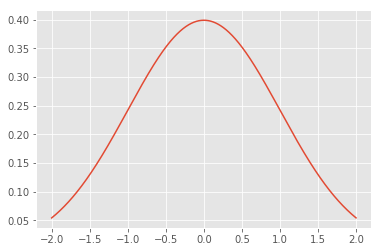

In [7]:
sess = ed.get_session()
ex = tf.range(-2.0,2.0, 0.001)
plt.plot(*sess.run([ex,Normal(loc = 0.0,scale =1.0).prob(ex)]));
# exact inference - ed.complete_conditional(pheads)
# pheads_post = ed.copy(pheads_cond, {bernoulli.model:observations})
# then run the session 
# plt.axvline(x=0.5) to plot the middle 

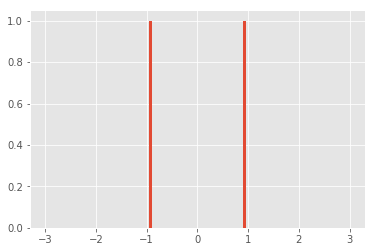

In [8]:
sess = ed.get_session()
tf.global_variables_initializer()
#samples = sess.run(qW_0.eval())
plt.hist(tf.transpose(qW_0).eval(), bins=100, range=(-3.0, 3.0))
plt.show()
#outputs = mus.eval()

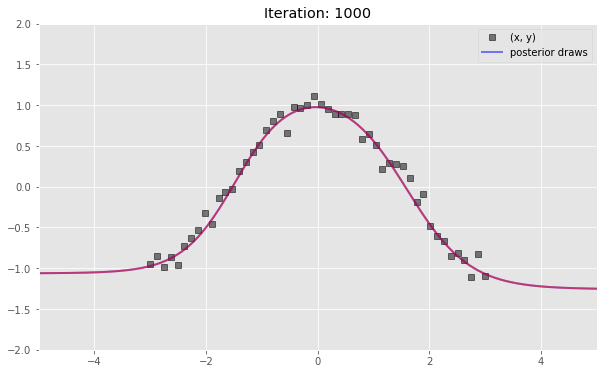

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0], 'b', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1], 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()